In [1]:
import sys
import os
sys.path.append(os.path.abspath('..'))

In [66]:
#imports
import torch
from torch.utils.data import Dataset
import numpy as np
from src.updated_model import HarvestModel
from torch.utils.data import DataLoader
import src.preprocessing as pre
from torch.utils.data import random_split
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
from src.updated_dataset import create_dataset
from src.updated_utils import create_model

In [4]:
from sklearn.model_selection import KFold
from torch.utils.data import Subset

In [91]:
meta, y, mapping_dict = pre.load_data('../data/meta.json','../data/y.csv','../data/mappings.json')

In [6]:
dataset = create_dataset(meta, y, mapping_dict)

fix this script when your brain is working properly lol. store actual results not just loss numbers

In [ ]:
results = np.zeros((len(dataset),4))

kfold = KFold(n_splits=5, shuffle=True)

for fold, (train_idx, val_idx) in enumerate(kfold.split(dataset)): #type: ignore
    train_dataset = Subset(dataset, train_idx) #type: ignore
    val_dataset = Subset(dataset, val_idx) #type: ignore

    model, val_loader = create_model(train_dataset, val_dataset, 50)

    model.eval()
    criterion = nn.MSELoss()
    with torch.no_grad():
        for batch in val_loader:
            features, ranch_id, class_id, type_id, variety_id, climate_data, y, bounds, idx = batch
            kilo_ranges = torch.arange(4,20,4)
            row_results = []
            batch_size = len(y)
            log_kilos = torch.log1p(y) 
            week_numbers = torch.arange(0, 20).unsqueeze(0).repeat(batch_size,1)
            inputs = torch.stack([y, log_kilos, week_numbers], dim=2)
            for kilo_range in kilo_ranges:
                
                kilo_inputs = inputs[:,:kilo_range.item(),:]
                outputs, clamp = model(features, ranch_id, class_id, type_id, variety_id, climate_data, kilo_inputs)
                loss = criterion(outputs, y)
                row_results.append(loss.item())

            for i, id in enumerate(idx):
                results[id.item()] += row_results[i]

        


Epoch [1/200], Loss: 9708760.9358
Epoch [2/200], Loss: 9307975.5811
Epoch [3/200], Loss: 8684218.5135
Epoch [4/200], Loss: 7573407.1216
Epoch [5/200], Loss: 7043470.9662
Epoch [6/200], Loss: 7076984.8260
Epoch [7/200], Loss: 7138414.6149
Epoch [8/200], Loss: 6923998.6047
Epoch [9/200], Loss: 6490280.5084
Epoch [10/200], Loss: 6026083.5169
Epoch [11/200], Loss: 5737278.0929
Epoch [12/200], Loss: 5539922.6250
Epoch [13/200], Loss: 5545086.3260
Epoch [14/200], Loss: 5588239.7095
Epoch [15/200], Loss: 5857855.0253
Epoch [16/200], Loss: 5964400.7348
Epoch [17/200], Loss: 6004604.6672
Epoch [18/200], Loss: 6209163.7078
Epoch [19/200], Loss: 6365727.0861
Epoch [20/200], Loss: 6413505.5068
Epoch [21/200], Loss: 6551034.2990
Epoch [22/200], Loss: 6764825.9966
Epoch [23/200], Loss: 6884289.1993
Epoch [24/200], Loss: 7044197.3826
Epoch [25/200], Loss: 6969864.4189
Epoch [26/200], Loss: 7272447.1959
Epoch [27/200], Loss: 7329187.5676
Epoch [28/200], Loss: 7526433.8193
Epoch [29/200], Loss: 7599986

In [29]:
row_results

[2433160.5, 2433173.0, 2433139.5, 2433136.0]

In [60]:
df = pd.DataFrame(data = results,columns = kilo_ranges.tolist(),index = meta.index) / 10

In [57]:
new_meta = pre.decode(meta,mapping_dict)



In [64]:
df1 = pd.concat([new_meta, df],axis=1)

In [95]:
total_kilos = y.sum(axis=1)


In [96]:
df1['Kilos'] = total_kilos

In [115]:
df1

,TransplantDate,Year,WeekTransplanted,Ranch,Variety,Class,Type,Ha,WeekTransplanted_sin,WeekTransplanted_cos,ClimateSeries,4,8,12,16,Kilos
2013-02-13_Felicity_ZJL_Z18_6_0.39,1360713600000,2013,7,ZJL,Felicity,CHE,Cherry Rojo,0.3938,0.748511,0.663123,"[[-0.5605881878, -3.1935067896000002, -0.25850...",1.131279e+06,1.132258e+06,1.125800e+06,1.105044e+06,43744.863372
2013-02-13_Shiren_ZJL_Z18_6_0.39,1360713600000,2013,7,ZJL,Shiren,CHE,Cherry Rojo,0.3938,0.748511,0.663123,"[[-0.5605881878, -3.1935067896000002, -0.25850...",1.003120e+06,1.003608e+06,9.959351e+05,9.769493e+05,47097.768225
2013-02-15_Amsterdam_ZJL_Z18_2_0.27,1360886400000,2013,7,ZJL,Amsterdam,BSUF,Uva Roja,0.2700,0.748511,0.663123,"[[0.3146673828, -1.2573452111, -0.258501094600...",8.342888e+05,8.350221e+05,8.242470e+05,8.134657e+05,15299.448747
2013-02-15_Felicity_ZJL_Z18_5_0.21,1360886400000,2013,7,ZJL,Felicity,CHE,Cherry Rojo,0.2138,0.748511,0.663123,"[[0.3146673828, -1.2573452111, -0.258501094600...",9.430391e+05,9.439757e+05,9.357402e+05,9.197942e+05,39419.948496
2013-02-15_Olivia_ZJL_Z18_2_0.54,1360886400000,2013,7,ZJL,Olivia,BSUF,Uva Roja,0.5400,0.748511,0.663123,"[[0.3146673828, -1.2573452111, -0.258501094600...",9.744620e+05,9.760046e+05,9.651936e+05,9.507282e+05,21146.170896
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-07-18_Tymoty_VAP_V02_37_0.18,1721260800000,2024,29,VAP,Tymoty,CHE,Cherry Rojo,0.1764,-0.354605,-0.935016,"[[0.2964328918, 0.5259615059, -0.2585010946000...",6.224647e+05,6.226947e+05,6.155687e+05,5.993652e+05,4361.751003
2024-07-24_Top 2417_VAP_V02_8_0.18,1721779200000,2024,30,VAP,Top 2417,CHE,Cherry Naranja,0.1805,-0.464723,-0.885456,"[[0.7705296592, 1.2392841928, 2.0075632228], [...",4.975038e+05,4.972304e+05,4.933889e+05,4.833526e+05,1500.568315
2024-07-29_King_SGB_S12_7_0.51,1722211200000,2024,31,SGB,King,BSUF,Uva Roja,0.5100,-0.568065,-0.822984,"[[-0.2323673488, 0.3476308342, -0.258501094600...",6.616400e+05,6.625596e+05,6.567685e+05,6.420787e+05,15539.181935
2024-07-29_King_SGB_S12_8_0.03,1722211200000,2024,31,SGB,King,BSUF,Uva Roja,0.0306,-0.568065,-0.822984,"[[-0.2323673488, 0.3476308342, -0.258501094600...",6.020771e+05,6.035798e+05,5.952777e+05,5.825389e+05,4668.952095


In [116]:
df_encoded = pd.get_dummies(df1.drop(columns=['ClimateSeries']), drop_first=True)


In [120]:
corr_matrix = df_encoded.corr()
corr_with_errors = corr_matrix[[4,8,12,16]]  # Select only the error metric columns


In [132]:
corr = corr_with_errors.drop(['TransplantDate','WeekTransplanted_sin','WeekTransplanted_cos',4,8,12,16])

In [138]:
corr.round(3)

,4,8,12,16
Year,-0.463,-0.463,-0.460,-0.462
WeekTransplanted,-0.087,-0.087,-0.090,-0.087
Ha,0.086,0.086,0.087,0.086
Kilos,0.298,0.298,0.298,0.297
Ranch_OAP,0.055,0.055,0.053,0.054
...,...,...,...,...
Type_Pera Amarilla,-0.093,-0.093,-0.092,-0.093
Type_Pera Roja,-0.089,-0.089,-0.089,-0.089
Type_Uva Amarilla,-0.030,-0.031,-0.031,-0.031
Type_Uva Roja,0.068,0.068,0.068,0.068


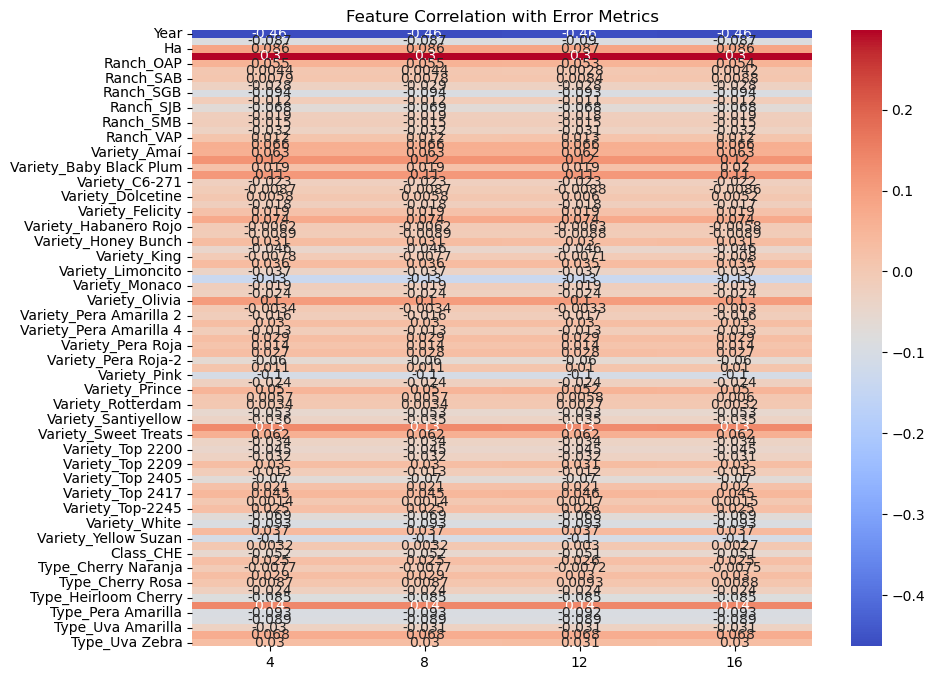

In [133]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.title("Feature Correlation with Error Metrics")
plt.show()

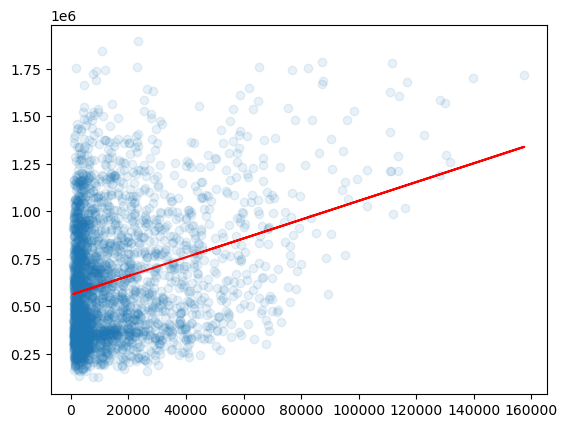

In [109]:
x = df1.Kilos
y = df1[16]

plt.scatter(x,y,alpha=0.1,)

coeffs = np.polyfit(x, y, deg=1)
trendline = np.poly1d(coeffs)
plt.plot(x, trendline(x), color='red', label='Trendline')